Цель работы:
- создание пайплайна загрузки изображений;
- работа с torchvision.datasets и DataLoader;
- предобработка и аугментации данных;
- подготовка данных для обучения модели классификации в PyTorch

In [ ]:
!pwd

/home/msalena/SFMaga/main_repo/cv_nn


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Загрузка и подготовка датасета

In [3]:
DATAPTH = './data/plant'

In [4]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tqdm

def download_and_save_data(path_dataset, output_dir='./data/plant', csv_path='./data/plant_dataset.csv'):
    os.makedirs(output_dir, exist_ok=True)
    data_info = []

    label_map = {
        'Potato_sick_late': 0,
        'Potato_sick_early': 1,
        'Potato_healthy': 2
    }

    idx = 0
    for path_dir in sorted(os.listdir(path_dataset)):
        full_dir = os.path.join(path_dataset, path_dir)
        if not os.path.isdir(full_dir):
            continue

        label = label_map.get(path_dir)
        if label is None:
            continue  # Skip unknown directories

        for filename in tqdm.tqdm(sorted(os.listdir(full_dir)), desc=f'Processing {path_dir}'):
            full_path = os.path.join(full_dir, filename)
            try:
                image = Image.open(full_path).convert("RGB").resize((180, 180))
                save_path = os.path.join(output_dir, f'{idx}.png')
                image.save(save_path)

                data_info.append([save_path, label])
                idx += 1
            except Exception as e:
                print(f"Failed to process {full_path}: {e}")

    # Сохраним манифест датасета в CSV файл
    df = pd.DataFrame(data_info, columns=['image_path', 'label'])
    df.to_csv(csv_path, index=False)
    print(f"\nSaved dataset info to {csv_path}")

    return df

In [5]:
df_train = download_and_save_data(
    r"/content/drive/MyDrive/Colab Notebooks/materials/Plants/Train",
    output_dir=DATAPTH + '/train',
    csv_path=DATAPTH + '/train/plant_dataset.csv'
)
df_test = download_and_save_data(
    r"/content/drive/MyDrive/Colab Notebooks/materials/Plants/Test",
    output_dir=DATAPTH + '/test',
    csv_path=DATAPTH + '/test/plant_dataset.csv'
)

Processing Potato_sick_late: 100%|██████████| 700/700 [00:27<00:00, 25.71it/s]



Saved dataset info to ./data/plant/train/plant_dataset.csv


Processing Potato_sick_late: 100%|██████████| 300/300 [00:08<00:00, 37.23it/s]


Saved dataset info to ./data/plant/test/plant_dataset.csv


In [6]:
df_train

,image_path,label
0,./data/plant/train/0.png,2
1,./data/plant/train/1.png,2
2,./data/plant/train/2.png,2
3,./data/plant/train/3.png,2
4,./data/plant/train/4.png,2
...,...,...
2095,./data/plant/train/2095.png,0
2096,./data/plant/train/2096.png,0
2097,./data/plant/train/2097.png,0
2098,./data/plant/train/2098.png,0


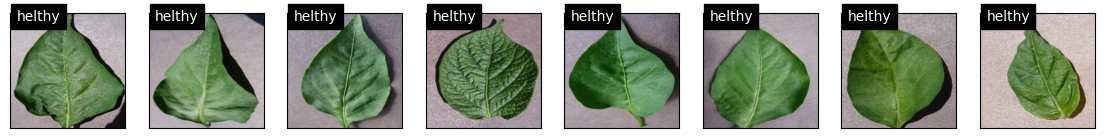

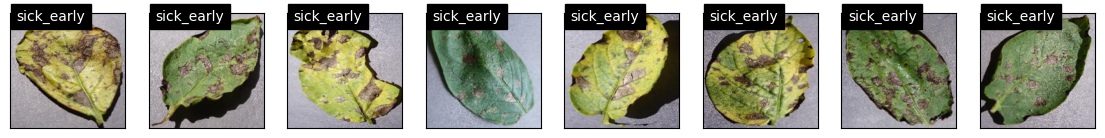

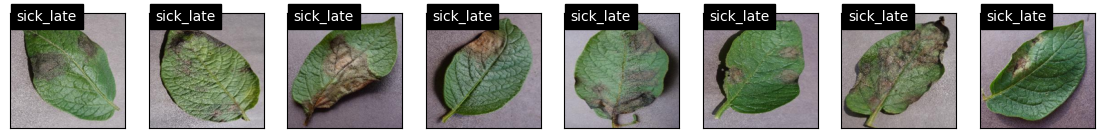

In [7]:
from matplotlib import pyplot as plt

def show_pics(df, in_line=8, text='', figsize=(14, 14), shift=0):
    plt.figure(figsize=figsize)
    for i in range(in_line):
        plt.subplot(1, in_line, i+1)
        plt.xticks([])
        plt.yticks([])
        pic = plt.imread(df.iloc[i+shift].image_path)
        plt.imshow(pic, cmap=plt.cm.binary)
        plt.text(10, 12, text, color='white', backgroundcolor='black', fontsize=10)



show_pics(df_train, text='helthy')
show_pics(df_train, text='sick_early', shift=900)
show_pics(df_train, text='sick_late', shift=1600)

In [8]:
display(df_train.label.value_counts())
df_test.label.value_counts()

,count
label,
2,700
1,700
0,700


,count
label,
2,300
1,300
0,300


# Пайплайн с Dataset и DataLoader

In [72]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as nn_f
from PIL import Image
import pandas as pd
import torch

class CustomDataset(Dataset):
    def __init__(self, csv_file=None, df_metadata=None, transform=None):

        if isinstance(df_metadata, pd.DataFrame):
            self.df_metadata = df_metadata
        else:
            self.df_metadata = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        impath = self.df_metadata.iloc[idx]['image_path']
        label = self.df_metadata.iloc[idx]['label']
        image = Image.open(impath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if not isinstance(image, torch.Tensor):
            image = nn_f.to_tensor(image)

        # there are expected image in (C, H, W) dimention after transform
        return image, label


def collate_fn(batch):
    # 1. Get imgaes and labels
    images, labels = zip(*batch)

    # 2. Padding images before stacking
    padded_imgs = []
    max_h = max(f.size(1) for f in images)
    max_w = max(f.size(2) for f in images)

    for f in images:
        pad = [
            (0, max_w - f.size(2)), # add zeroes to the end of weight
            (0, max_h - f.size(1)), # add zeroes to the end of hight
        ]
        padded_imgs.append(torch.nn.functional.pad(f, pad))

    # 3. Stack images
    features = torch.stack(padded_imgs)

    # 4. Labesl to tensor
    labels = torch.stack(labels, dtype=torch.long)

    return features, labels


# Итерация по DataLoader

In [73]:
df_train

,image_path,label
0,./data/plant/train/0.png,2
1,./data/plant/train/1.png,2
2,./data/plant/train/2.png,2
3,./data/plant/train/3.png,2
4,./data/plant/train/4.png,2
...,...,...
2095,./data/plant/train/2095.png,0
2096,./data/plant/train/2096.png,0
2097,./data/plant/train/2097.png,0
2098,./data/plant/train/2098.png,0


In [74]:
from torch.utils.data import DataLoader
import time
from torchvision.utils import make_grid

# 1. Setting variables
BATCH_SIZE = 64
NUM_WORKERS = 2
SHUFFLE = True
CLASSES = [
    "healthy", "'sick_early'", "'sick_late'"
]

# 2. Augmentation and preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

# 3. Get data
dataset = CustomDataset(df_metadata=df_train, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)


# 4. Forward the dataload with learning pred_labels imitation and time calculating
loss_fn = torch.nn.CrossEntropyLoss()
start_time = time.time()
for i, (images, labels) in enumerate(dataloader):

  current_size = images.shape[0]
  imit_pred_labels = torch.randn(current_size, len(CLASSES))
  loss = loss_fn(imit_pred_labels, labels)

  print(f"Batch {i} - shape: {images.shape} ::: loss {loss}")

end_time = time.time()
print(f"\n⏱ Total iteration time: {end_time - start_time:.2f} seconds")

Batch 0 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.4150559902191162
Batch 1 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.435113787651062
Batch 2 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.214450478553772
Batch 3 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.5603681802749634
Batch 4 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.4944740533828735
Batch 5 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.360205054283142
Batch 6 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.5791245698928833
Batch 7 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.3148798942565918
Batch 8 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.3575712442398071
Batch 9 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.4251779317855835
Batch 10 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.3138478994369507
Batch 11 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.1855077743530273
Batch 12 - shape: torch.Size([64, 3, 180, 180]) ::: loss 1.3010735511779785
Batch 13 - shape: torch.S

# Оценика производительности пайплайна

Тезисы:
1. В текущей реализации загрузка и трансформации изображений происходят побатчево в процессе итерации по даталоду. Такой подход позволяет не хранить все в оперативной памяти, а также более гибко настраивать обучение. GPU ускоряет модель, но загрузка и подготовка данных всё равно зависит от CPU и диска.

2. В тоже время, вызов препроцессинга в момент создания объекта класса также может иметь свои плюсы, поскольку зачастую матричные перемножения работаю быстрее на всех данных в противовес излишнему дроблению. Плюс и само обучение на уже предобработанных данных будет проходить быстрее.

3. В зависимотси от возможностей диска стоит рассмотреть увеличение num_workers до 4-8

4. Если в последующем пайплайне обучения планируется фиксировать размер изображений (transform Resize), или если мы знаем, что все изображения и так имеют олдинаковую длину, можно убрать паддинг и использовать обычный stack без доп. затрат.

# Визуализация данных

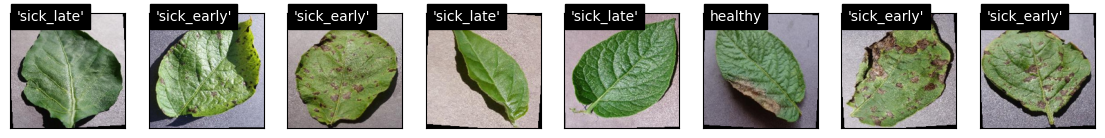

In [90]:
# Visualize last images
last_batch_images = images.numpy()
last_batch_labels = labels

plt.figure(figsize=(14, 14))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        last_batch_images[i].transpose(1, 2, 0), # (C, H, W) -> (H, W, C)
        cmap=plt.cm.binary # Mode for black-white pics (ignored on colored pics)
    )
    text_label = CLASSES[last_batch_labels[i]] # Decode classes
    plt.text(10, 12, text_label, color='white', backgroundcolor='black', fontsize=10)